# Imports

In [1]:
import numpy as np
import pprint as pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict

from sklearn.metrics import log_loss, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from scipy.stats import loguniform

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

import warnings
warnings.filterwarnings('ignore')

# Data Fetching

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
X = X.to_numpy()
y = y.to_numpy()

In [4]:
target_names = np.unique(y)
print(f'Number of samples: {X.shape[0]}, type: {X.dtype}')
print(f'Number of features: {X.shape[1]}')

Number of samples: 70000, type: float64
Number of features: 784


In [5]:
print('Minimum: ', np.min(X))
print('Maximum: ', np.max(X))

Minimum:  0.0
Maximum:  255.0


In [6]:
print(f'Number of classes: {len(target_names)}, type: {y.dtype}')
print(f'Labels: {target_names}')

Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


# Preprocessing

In [7]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [8]:
print('Minimum: ', np.min(X))
print('Maximum: ', np.max(X))

Minimum:  0.0
Maximum:  1.0


# Data Visualisation

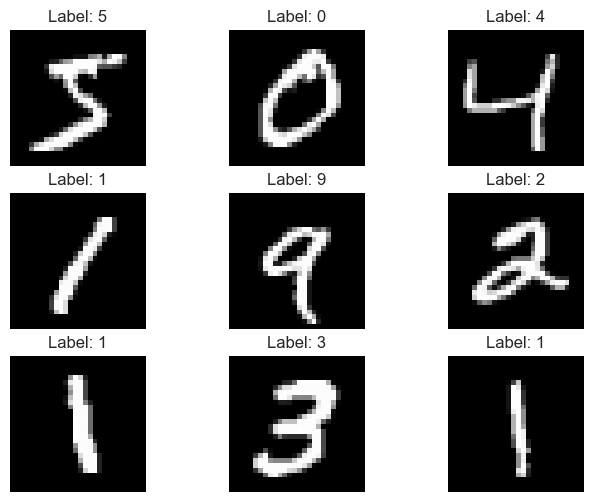

In [9]:
#choosing a square number (9 in this case)
num_images = 9
factor = int(np.sqrt(num_images))

fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))

#take "num_images" starting from the index "idx_offset"
idx_offset=0

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Label: {str(y[index+j])}')
        ax[i,j].set_axis_off()

# Data Splitting

In [10]:
#data is already shuffled randomly
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Visualisation of Distribution of Samples

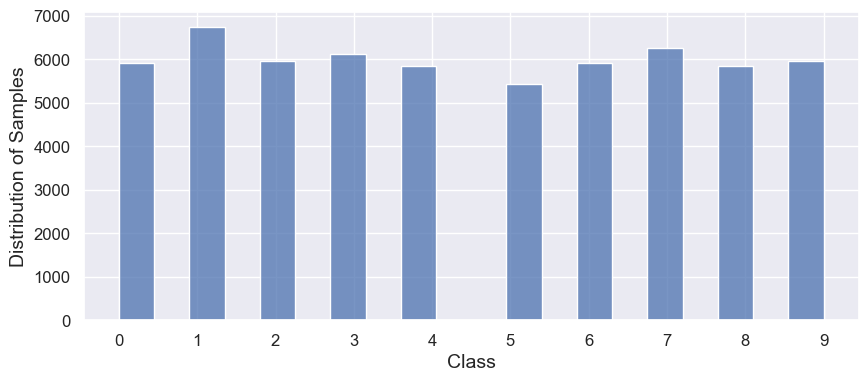

In [11]:
plt.figure(figsize=(10,4))

sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
           labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.xlabel('Class')
plt.ylabel('Distribution of Samples')
plt.show()

# Multiclass Logistic Regression using SGDClassifier

### Model Building

In [12]:
estimator = SGDClassifier(loss='log', penalty='l2', alpha=0, max_iter=1, random_state=1729, learning_rate='constant', eta0=0.01, warm_start=True)
pipe_sgd_ova = make_pipeline(MinMaxScaler(), estimator)

In [13]:
loss = []
iter = 100

for i in range(iter):
    pipe_sgd_ova.fit(X_train, y_train)
    
    y_pred = pipe_sgd_ova.predict_proba(X_train)
    loss.append(log_loss(y_train, y_pred))

### Visualisation of Loss vs Iterations

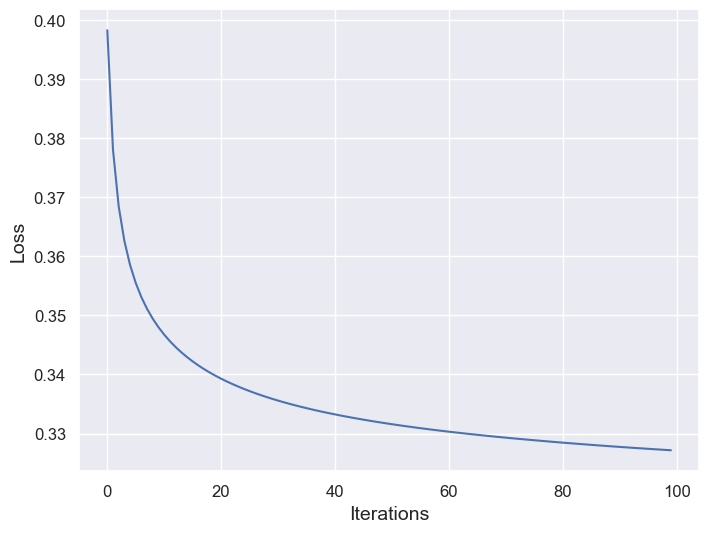

In [14]:
plt.figure()
plt.plot(np.arange(iter), loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

### Looking at 1 of the 10 Binary Classifiers

In [15]:
pipe_sgd_ova

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant',
                               loss='log', max_iter=1, random_state=1729,
                               warm_start=True))])

In [16]:
pipe_sgd_ova[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=1729, warm_start=True)

In [17]:
pipe_sgd_ova[1].coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
pipe_sgd_ova[1].coef_.shape

(10, 784)

### Making Predictions

In [19]:
y_hat = pipe_sgd_ova.predict(X_test)
y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

### Visualising Predictions

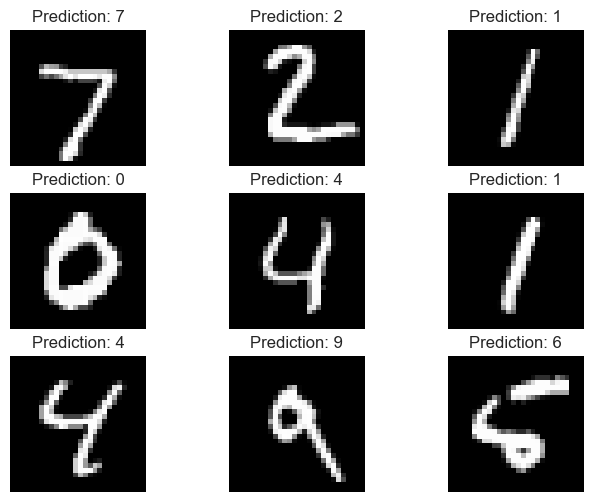

In [20]:
num_images = 9 
factor = int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Prediction: {0}'.format(str(y_hat[index+j])))
        ax[i,j].set_axis_off()

### Evaluating Metrics

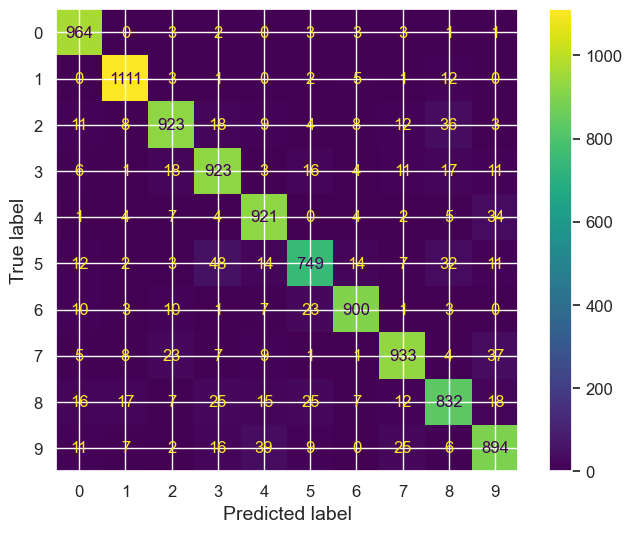

In [21]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [22]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



# Multiclass LogisticRegression Using Solvers

### Model Building

In [23]:
pipe_logreg_ova = make_pipeline(MinMaxScaler(), LogisticRegression(solver='lbfgs', C=np.infty, random_state=1729))
pipe_logreg_ova.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

### Making Predictions

In [24]:
y_hat = pipe_logreg_ova.predict(X_test)
y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype=object)

### Visualising Predictions

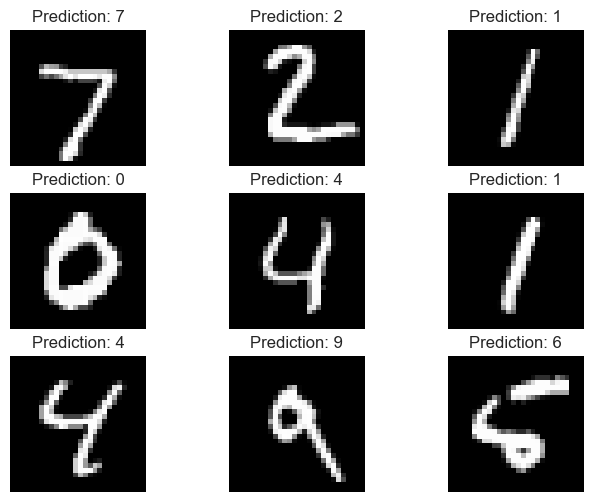

In [25]:
num_images = 9 
factor = int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 

for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Prediction: {0}'.format(str(y_hat[index+j])))
        ax[i,j].set_axis_off()

### Evaluating metrics

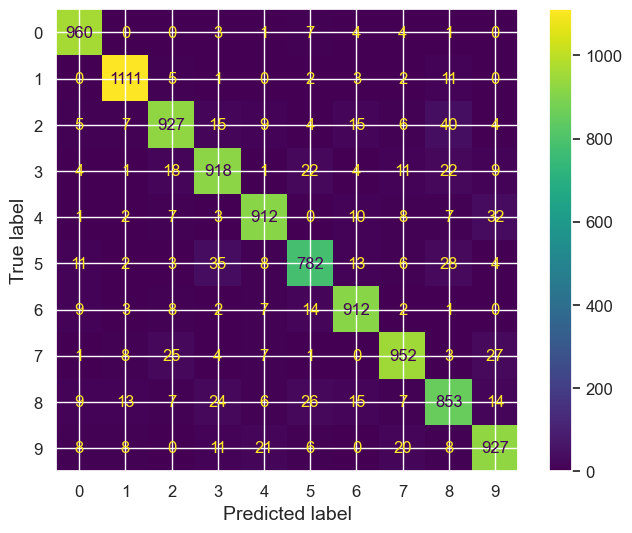

In [27]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [28]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



### Visualising Weight Values

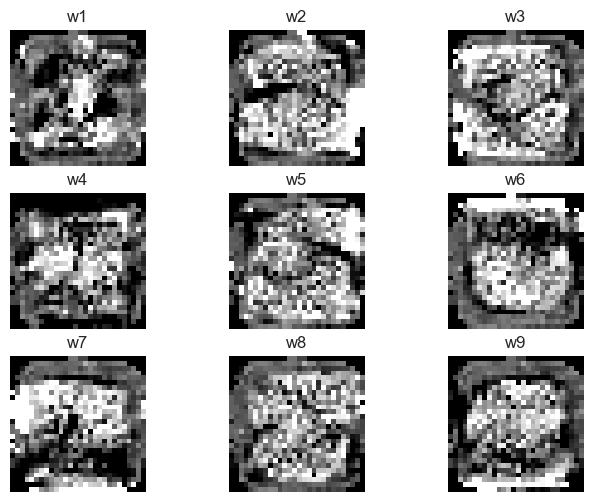

In [29]:
w = pipe_logreg_ova[1].coef_

#normalisation
w = MinMaxScaler().fit_transform(w)
fig, ax = plt.subplots(3, 3)
index = 1

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(w[index, :].reshape(28,28), cmap='gray')
        ax[i][j].set_title(f'w{index}')
        ax[i][j].set_axis_off()
        index+=1